# Cleaning and Preprocessing

### Imports

https://github.com/sanjeevai/disaster-response-pipeline/blob/master/models/train_classifier.py

In [1]:
# high resolution notebooks
%config InlineBackend.figure_format ='retina'

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import databases
import dataloader

In [3]:
def make_cloud(X):
    '''
    Uses X value of data, which should be text columns
    
    Returns:
    image
    '''

    wc = wordcloud.WordCloud(max_words=50, 
                             width=700, 
                             height=400, 
                             background_color='white',
                            )

    

    cloud = wc.generate(X.str.cat())

    return cloud.to_image()



## Import the data

In [4]:
subreddit_list = ['css', 'html', 'javascript', 'php', 'perl', 'java', 'datascience', 'machinelearning', 'etl', 'python']

In [5]:
# subreddit_list = ['datascience','sql']

In [6]:
df = dataloader.data_selector(subreddit_list, 'sqlite')

Connection to SQLite DB successful
No data for javascript, not adding to df
No data for php, not adding to df
No data for perl, not adding to df
No data for java, not adding to df
No data for etl, not adding to df
No data for python, not adding to df


In [7]:
subreddit_list = [sub for sub in subreddit_list if sub in df.subreddit.unique()]

In [8]:
subreddit_list

['css', 'html', 'datascience', 'machinelearning']

In [9]:
df = dataloader.subreddit_encoder(df)

Topic dict to make sure: {'datascience': 0, 'html': 1, 'css': 2, 'machinelearning': 3}


In [10]:
df.sample(10)

,title,subreddit,date,sub_code
228,Does a data scientist have to know something a...,datascience,2020-03-10,0
615,Is there a way to submit jobs to an on-demand ...,datascience,2020-03-10,0
2899,Let a user set a cookie,html,2020-03-10,1
2099,Ultimate v1.1 Release of Yellowbrick (Open Sou...,datascience,2020-03-10,0
2448,Starting 'Analyzing Data with Python' IBM cour...,datascience,2020-03-10,0
628,Resources for ethical use of data,datascience,2020-03-10,0
4697,[D] Graph-specific Loss Function?,machinelearning,2020-03-10,3
2906,HTML to expand Google Scholar profile,html,2020-03-10,1
325,Help me ! I need guidance,datascience,2020-03-10,0
1842,Prediction method,datascience,2020-03-10,0


In [11]:
X = df['title']
y = df['sub_code']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [13]:
useless_words = set(['using', 'help', 'new', 'data', 'science', 'machine', 'learning'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [14]:
pipe = Pipeline([('count_vec', CountVectorizer()), ('lr', LogisticRegression())])

In [15]:
pipe_params = {
                'count_vec__max_features': [1000,2000,3000,4000,5000],
                'count_vec__max_df': [.3,.4,.5],
                'count_vec__ngram_range': [(1,2),(1,3)],
                'count_vec__stop_words': [custom_stop_words],
                'count_vec__min_df': [3,5,10, 20],
                'lr__penalty': ['l1','l2'],
                'lr__C': [.01, .1, 1, 5, 10]
                }

In [16]:
model = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose=1, n_jobs=-1)

In [17]:
model.fit(X_train, y_train);

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.0min
/Users/chris/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Para

In [18]:
print(f'Best Modeling Score: {model.best_score_}')

print(f'Train Score: {model.score(X_train, y_train)}')

print(f'Test Score: {model.score(X_test, y_test)}')

Best Modeling Score: 0.8147547628698825
Train Score: 0.9639237940818808
Test Score: 0.8328267477203647


In [19]:
# model is GridSearchCV
# best_estimator is Pipeline
# named_steps is the steps in the pipeline
# count_vec is the FITTED 

features_data = model.best_estimator_.named_steps.count_vec.transform(X).toarray()
features_columns = model.best_estimator_.named_steps.count_vec.get_feature_names()

In [20]:
features_df = pd.DataFrame(data=features_data, columns=features_columns)

## You know what would be cool?  Stacked bar graph of all of them!!

In [38]:
### CHECK ### does this function work with tfidf, or just count vec?
###HELP### this kinda looks like shit when only using 3 features, 2 columns if features below X value?
def plot_most_common(df, features_df, num_features=20, standardize=False, include_combined=False):
    '''
    Plots the most common features for each subreddit in the DataFrame
    
    Parameters:
    
    df: original DataFrame
    
    features_df: should be output from transformer on df
        
        Example:
        features_df = pd.DataFrame(
                                data={transformer}.transform(X).toarray(),
                                columns={transformer}.get_feature_names())
    
    num_features: number of most common features to plot for each subreddit
    
    standardize: put all of the plots on the same scale
    
    combined: include a plot of the most common features of all of the subreddits combined
    
    Returns:
    
    plots
    
    '''

    fig, ax = plt.subplots(ncols=1, 
                           nrows=len(subreddit_list) + int(1 if include_combined else 0), 
                           figsize=(15,num_features/1.5*len(subreddit_list)))
    fig.tight_layout()

    for subplot_idx, sub in enumerate(subreddit_list):
        sub_features = features_df.loc[df['subreddit'] == sub]
        sub_top_words = sub_features.sum().sort_values(ascending=False).head(num_features)[::-1]
        sub_top_words.plot(kind='barh', ax=ax[subplot_idx])
        ax[subplot_idx].set_title(f'{num_features} Most Common Words for {sub.upper()}', fontsize=16)
        if standardize:
            max_occurence = features_df.sum().max()
            ax[subplot_idx].set_xlim(0,max_occurence)

    if include_combined:
        most_common = features_df.sum().sort_values(ascending=False).head(num_features)[::-1]
        most_common.plot(kind='barh', ax=ax[subplot_idx+1])
        ax[subplot_idx+1].set_title(f'{num_features} Most Common Words for {subreddit_list}')
        if standardize:
            max_occurence = features_df.sum().max()
            ax[subplot_idx+1].set_xlim(0,max_occurence)

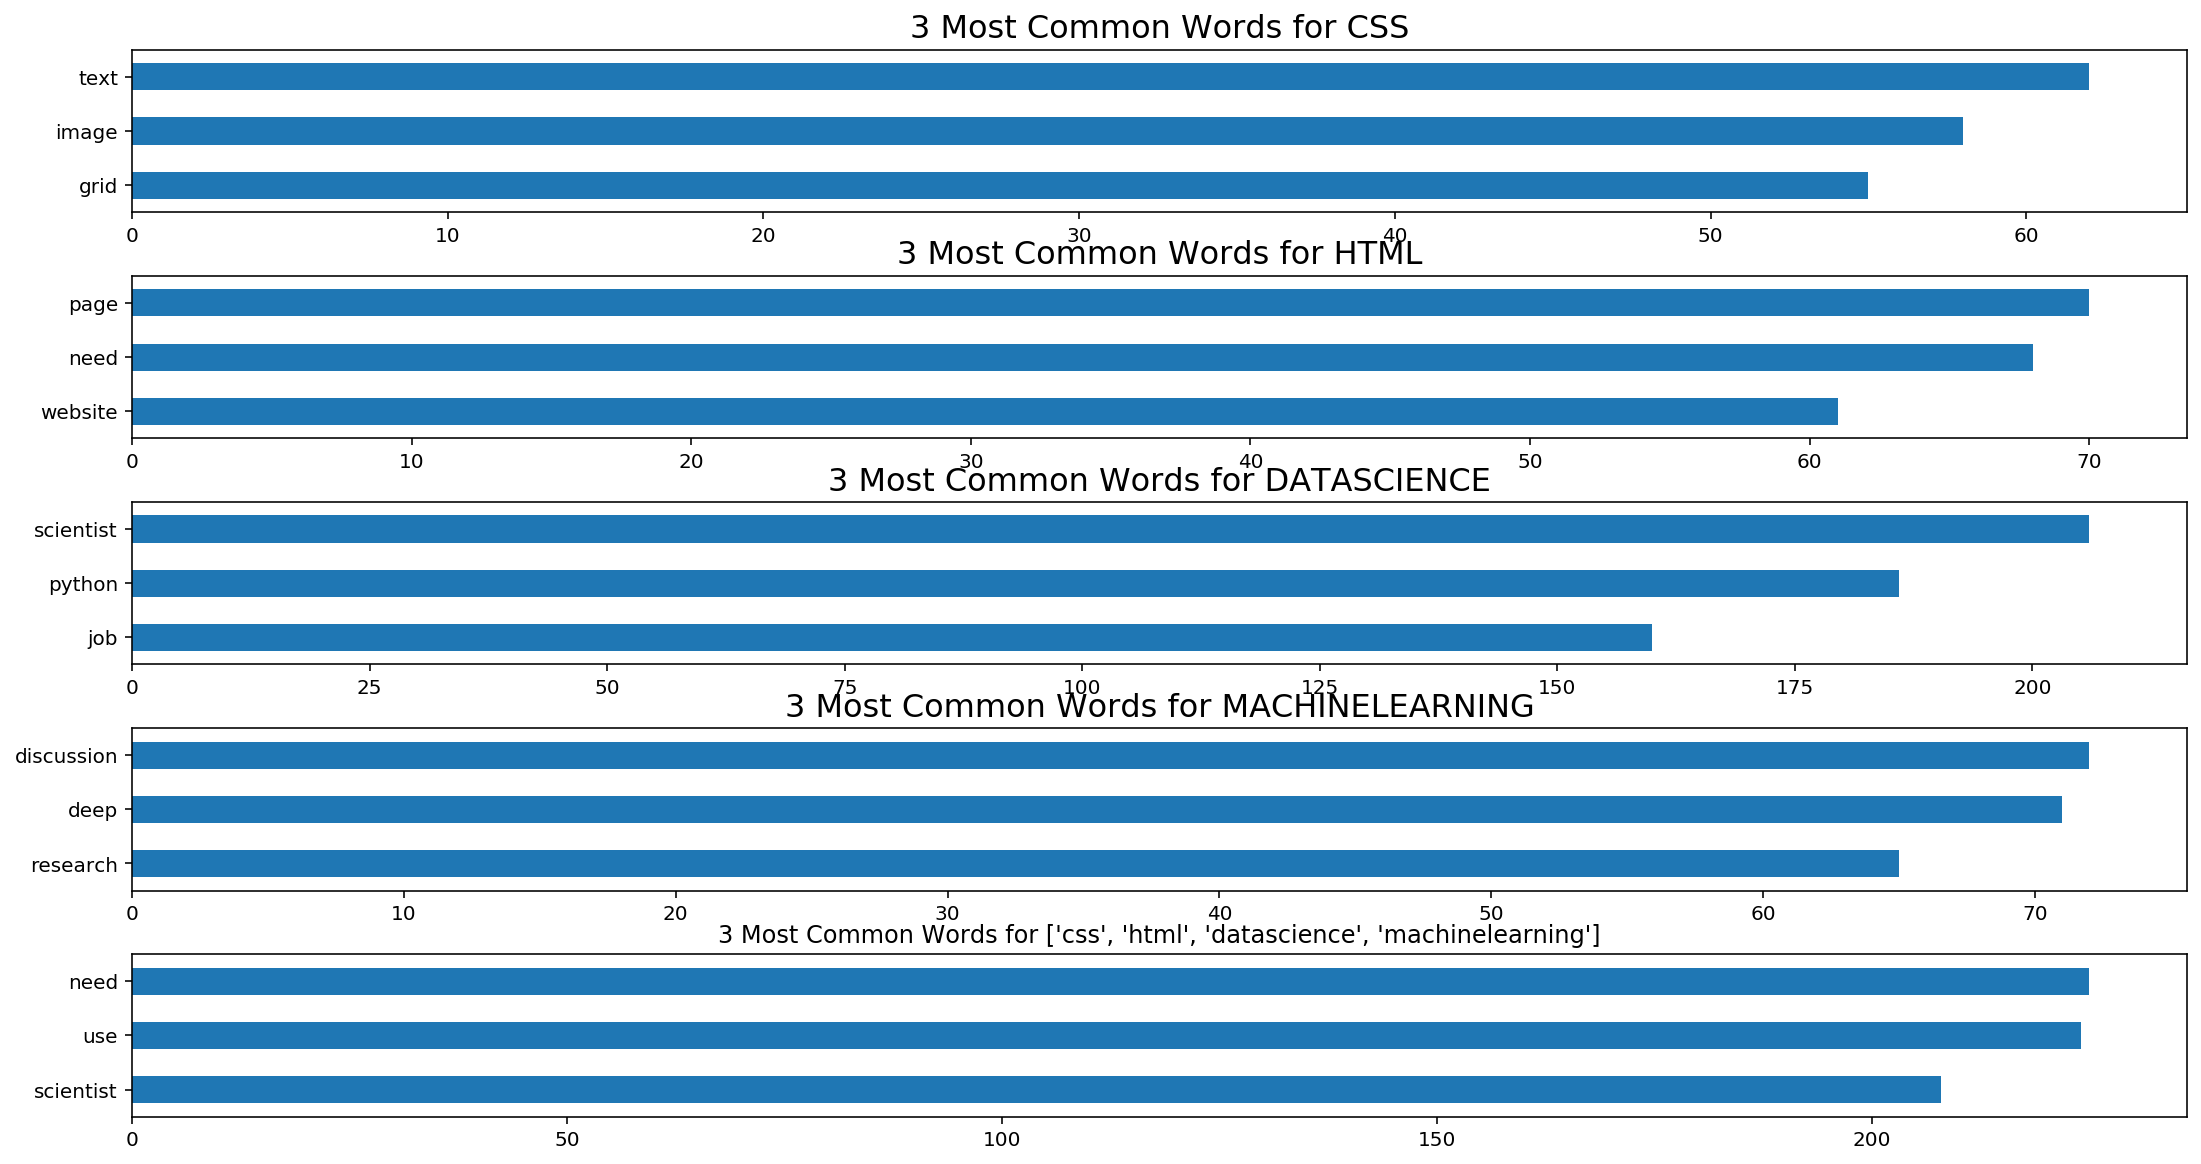

In [39]:
plot_most_common(df, features_df, num_features=3, include_combined=True)

## Feature Importance Coefficients

In [ ]:
###HELP### I don't think this is working right

In [ ]:
###NOTE### coefficients only for lr and etc etc etc...
###NOTE### coefficients only for two subreddits


# [-1][1] for last step (estimator)(instantiation)
# coef_[0]because I don't know why
coefs = model.best_estimator_.steps[-1][1].coef_[0]




plt.figure(figsize=(16, 12))
plt.title('Feature Importance (Coefficients)', fontsize=20)
plt.ylabel('Features', fontsize=18)
plt.xlabel('(Abs) Coefficients', fontsize=18)

coef_df = pd.DataFrame(data=[coefs], columns=features_columns).T
coef_df['abs_coef'] = coef_df[0].abs()
coef_df.sort_values('abs_coef', ascending=False)[0].head(15).plot(kind='barh');

# coef_kill = coef_df.sort_values('abs_coef', ascending=False)[0].head(500).index

# coef_kill


# my_stops.extend(coef_kill)

## ToDo for this section

1. make each of these functions only take two 

In [ ]:
from itertools import combinations

In [ ]:
if len(subreddit_list) > 2:
    sub_combos = list(combinations(subreddit_list,2))



In [ ]:
sub_combos

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
df.loc[base_common.index].sum().plot.barh(ax=ax1, title='Science', color='navy')
ax1.set_xlim(0,2800)
ax2.set_xlim(0,2800)
df[base_common.index].sum().plot.barh(ax=ax2, title='Technology', color='orange');

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))


groups = features.groupby(df['subreddit']).sum()[base_common.index].T.head(20)
plt.title('20 Most Common Words', fontsize=20)

groups.plot.bar(
                ax=ax,
                width=.8,
                # set style for colors instead of have to choose individually
                color=['gray','navy','orange','purple','red'],
                fontsize=15,
                );

# Word Clouds!!!

### Entire dataset

In [ ]:
make_cloud(X)

In [ ]:
fig = plt.figure(figsize=(14, 6*len(trimmed_list)))
for i, sub in enumerate(trimmed_list):
    ax = fig.add_subplot(len(trimmed_list),1,i+1)
    cloud = make_cloud(X=df[df['subreddit'] == sub]['title'])
    

    ax.set_title(topic.upper(), fontdict={'fontsize': 24})
    ax.imshow(cloud)
    ax.axis('off')


## To Do for this section

1. Confusion Matrix for all selected Topics
2. Make a function that will compare all topics in 1x1 fasion, find combinatorics or whatever Python library
3. Output each of the comparisons if a list of more than 2.

## Confusion Matrix

In [ ]:
lr_predictions = lr_grid.predict(X_test)

In [ ]:
lr_cm = confusion_matrix(y_test, lr_predictions)

In [ ]:
lr_confusion_df = pd.DataFrame(lr_cm, columns=topics, index=topics)

lr_confusion_df

In [ ]:
tn, fp, fn, tp = lr_cm.ravel()

### Specificity

In [ ]:
lr_spec = tn / (tn + fp)
lr_spec

### Sensitivity/Recall

In [ ]:
lr_sens = tp / (tp +fn)
lr_sens

### ROC AUC Score

In [ ]:
lr_auc = roc_auc_score(y_test, lr_predictions)
lr_auc

### ROC AUC Curve

In [ ]:
lr_probs = lr_grid.predict_proba(X_test)[:,1]

In [ ]:
# not multiclass
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_probs)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(lr_fpr, lr_tpr, label=f'ROC curve (area = {lr_auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Logistic Regression', size=20)
plt.legend(fontsize=14);

# Histograms!

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(lr_probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(lr_probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(lr_probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)